In [1]:
!pip install deepspeed
import deepspeed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[2023-06-20 13:55:14,727] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
!pip install datasets==2.12.0
!pip install transformers==4.28.0
!pip install --upgrade accelerate
!pip install -q transformers datasets
#!pip install sklearn==1.2.2
!pip install torch==2.0.1
!pip install torchvision==0.15.2
!pip install peft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from transformers import TrainingArguments, Trainer, ViTImageProcessor, ViTForImageClassification, AutoImageProcessor
from torch.utils.data import DataLoader
import torch
from torchvision.transforms import Normalize, ToTensor, Compose, transforms
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
# DeepSpeed requires a distributed environment even when only one process is used.
# This emulates a launcher in the notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [5]:
class setupPipeline:
    """A pipeline for setting up the input images into the required format for training and inference
    Args:
          dataset_name(str): The name of the dataset to extract from the datasets library
          train_size(int): The size of the train dataset to extract from the datasets library
          test_size(int): The size of the test dataset to extract from the datasets library
          validation_split(float): A ratio for splitting the training data
          shuffle_data(bool): Wether to shuffle the data
          model_checkpoint(str): A pretrained model checkpoint from HuggingFace
          image_transformation(obj): An object specifying the type of image transformation required
    """
    def __init__(self, dataset_name, train_size, test_size, validation_split, shuffle_data, model_checkpoint):
        self.dataset_name = dataset_name
        self.train_size = train_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.shuffle_data = shuffle_data
        self.model_checkpoint = model_checkpoint
        self.image_transformation = None

    def load_data(self):
        """Load the required dataset using the load_dataset method
        """
        ds = load_dataset(self.dataset_name) #, split=['train[:' + str(self.train_size) + ']', 'test[:'+ str(self.test_size) + ']']) #, split=['train[:' + str(self.train_size) + ']', 'test[:'+ str(self.test_size) + ']'])

        return ds['train'], ds['test']

    def image_transform(self, data):
        """Transform the input images to pixel values
        Args:
            Data(dataset): A dataset containing the images, labels, and pixel values
        Returns:
            An updated dataset with transformed pixel values
        """
        data['pixel_values'] = [self.image_transformation(image.convert("RGB")) for image in data['image']]
        return data

    def preprocess_data(self, train_ds, test_ds):
        """Preprocess the input images to the required format by applying various transformations
        Args:
            train_ds(dataset): A train dataset containing the images, labels, and pixel values
            test_ds(dataset): A test dataset containing the images, labels, and pixel values
        Returns:
            The train, validation, and test datasets with transformation applied; the id2label and label2id maps, and the model image processor
        """
        # Split the data into train and validation sets
        train_ds = train_ds.shuffle(seed=42).select(range(self.train_size))
        test_ds = test_ds.shuffle(seed=42).select(range(self.test_size))

        splits = train_ds.train_test_split(test_size=self.validation_split, shuffle=self.shuffle_data)
        train_ds = splits['train']
        val_ds = splits['test']
        # Map labels to ids and ids to labels
        id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
        label2id = {label:id for id,label in id2label.items()}
        # Define the image processor based on a checkpoint ViT model to process the images
        processor = ViTImageProcessor.from_pretrained(self.model_checkpoint)
        # Normalize, resize, and convert the images to tensor format
        image_mean, image_std = processor.image_mean, processor.image_std
        normalize = Normalize(mean=image_mean, std=image_std)
        # The pretrained model uses 224x224 images only; upscale the input images to this size
        self.image_transformation = Compose([ToTensor(), normalize, transforms.Resize((224, 224))])
        # Apply the transformation on the datasets
        train_ds.set_transform(self.image_transform)
        val_ds.set_transform(self.image_transform)
        test_ds.set_transform(self.image_transform)
        return train_ds, val_ds, test_ds, id2label, label2id, processor

class runPipeline(setupPipeline):
    """A pipeline for executing the training and inference steps
    Args:
          learning_rate (float): The initial learning rate for AdamW optimizer
          per_device_train_batch_size (int): The batch size per GPU/TPU core/CPU for training
          per_device_eval_batch_size (int): The batch size per GPU/TPU core/CPU for evaluation
          num_train_epochs (int): Number of epoch to train
          weight_decay (float): The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights
          eval_metric(str): A evaluation metric to be displayed when training
          pipeline_type(str): Specifying whether to use the pipeline for training or making prediction
          dataset_name(str): The name of the image dataset
          train_ds(dataset): A train dataset containing the images, labels, and pixel values
          val_ds(dataset): A validation dataset containing the images, labels, and pixel values
          test_ds(dataset): A test dataset containing the images, labels, and pixel values
          label2id(dict): A dictionary to map labels to ids
          id2label(dict): A dictionary to map ids to labels
          model_checkpoint(str): Specifying the model checkpoint based on the HuggingFace API
          processor(obj): A torchvision object for tokenizing the images
          torch_weights_filename(str): A pytorch file containing the fine-tuned weights of the model
          device (obj): Specifies whether to use cpu or gpu
          apply_lora (bool): Whether to apply Lora
          load_weights (bool): Whether to saved torch weights
    """
    def __init__(self, learning_rate, per_device_train_batch_size, per_device_eval_batch_size, num_train_epochs, weight_decay, eval_metric, pipeline_type, dataset_name, train_ds, val_ds, test_ds, label2id, id2label, model_checkpoint, processor, torch_weights_filename, device, apply_lora, load_weights):
        self.learning_rate = learning_rate
        self.per_device_train_batch_size = per_device_train_batch_size
        self.per_device_eval_batch_size = per_device_eval_batch_size
        self.num_train_epochs = num_train_epochs
        self.weight_decay = weight_decay
        self.eval_metric = eval_metric
        self.pipeline_type = pipeline_type
        self.dataset_name = dataset_name
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.test_ds = test_ds
        self.label2id = label2id
        self.id2label = id2label
        self.model_checkpoint = model_checkpoint
        self.processor = processor
        self.torch_weights_filename = torch_weights_filename
        self.device = device
        self.apply_lora = apply_lora
        self.load_weights = load_weights

    def collate_fn(self, data):
        """A custom collate function for the dataLoader
        Args:
            data(list): List of individual samples
        Returns:
            A dictionary containing the batched pixel values and labels
        """
        pixel_values = torch.stack([d["pixel_values"] for d in data])
        labels = torch.tensor([d["label"] for d in data])
        return {"pixel_values": pixel_values, "labels": labels}

    def compute_metrics(self, eval_pred):
        """Compute evaluation metrics based on the predicted and true labels
        Args:
            eval_pred (tuple): Tuple containing predicted labels and true labels.
        Returns:
            A dictionary containing the computed evaluation metrics
        """
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return dict(accuracy=accuracy_score(predictions, labels))

    def execute_pipeline(self):
        """Execute the pipeline based on the specified pipeline type
        Returns:
            The Trainer object for training or prediction
        """
        # Load the ViT model for image classification
        model = ViTForImageClassification.from_pretrained(self.model_checkpoint, id2label=self.id2label, label2id=self.label2id, ignore_mismatched_sizes=True)
        if self.load_weights: model.load_state_dict(torch.load("./" + self.torch_weights_filename, map_location=torch.device(self.device.type)))
        if self.apply_lora: model = get_peft_model(model, peft_config)
        # Set the training arguments for the Trainer
        args = TrainingArguments(
            output_dir = self.dataset_name,
            save_strategy = "epoch",
            evaluation_strategy = "epoch",
            learning_rate = self.learning_rate,
            per_device_train_batch_size = self.per_device_train_batch_size,
            per_device_eval_batch_size = self.per_device_eval_batch_size,
            num_train_epochs = self.num_train_epochs,
            weight_decay = self.weight_decay,
            load_best_model_at_end = True,
            metric_for_best_model = self.eval_metric,
            logging_dir = 'logs',
            remove_unused_columns = False,
            deepspeed="./ds_config_zero3.json"
        )
        # Check the pipeline type and create the Trainer accordingly
        if self.pipeline_type.lower() == "train":
            executor = Trainer(
                model=model,
                args=args,
                train_dataset=self.train_ds,
                eval_dataset=self.val_ds,
                data_collator=self.collate_fn,
                compute_metrics=self.compute_metrics,
                tokenizer=self.processor
            )
        if self.pipeline_type.lower() == "predict":
            # Load the pre-trained weights for prediction
            executor = Trainer(
                model=model,
                args=args,
                train_dataset=self.train_ds,
                eval_dataset=self.val_ds,
                data_collator=self.collate_fn,
                compute_metrics=self.compute_metrics,
                tokenizer=self.processor
            )
        return executor

    def visualize_results(self, preds):
        """Visualize the evaluation results
        Args:
            preds(obj): A transformer object containing prediction outputs
        Returns:
            None
        """
        # Print the evaluation metrics
        print(f"\n\n{preds.metrics} \n")
        # Get the true labels and predicted labels
        y_true = preds.label_ids
        y_pred = preds.predictions.argmax(1)
        # Get the label names
        labels = self.test_ds.features['label'].names
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Create a ConfusionMatrixDisplay and plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(xticks_rotation=45)

class imageClassification:

    def __init__(self, test_folder_path, fine_tuned_model, num_img_show, device):
        self.test_folder_path = test_folder_path
        self.fine_tuned_model = fine_tuned_model
        self.num_img_show = num_img_show
        self.device = device

    def load_data(self):
        """Load the required dataset using the load_dataset method
        """
        ds = load_dataset(self.test_folder_path)
        return ds['test']

    def image_transform(self, data):
        """Transform the input images to pixel values
        Args:
            Data(dataset): A dataset containing the images, labels, and pixel values
        Returns:
            An updated dataset with transformed pixel values
        """
        data['pixel_values'] = [self.image_transformation(image.convert("RGB")) for image in data['image']]
        return data

    def preprocess_data(self, test_data):
        """Preprocess the input images to the required format by applying various transformations
        Args:
            test_data(dataset): A test dataset containing the images, labels, and pixel values
        Returns:
            The test datasets with transformation applied; the id2label and label2id maps, and the model image processor
        """
        # Map labels to ids and ids to labels
        # Define the image processor based on a checkpoint ViT model to process the images
        # Normalize, resize, and convert the images to tensor format
        processor = ViTImageProcessor.from_pretrained(self.fine_tuned_model)
        image_mean, image_std = processor.image_mean, processor.image_std
        normalize = Normalize(mean=image_mean, std=image_std)
        # The pretrained model uses 224x224 images only; upscale the input images to this size
        self.image_transformation = Compose([ToTensor(), normalize, transforms.Resize((224, 224))])
        # Apply the transformation on the datasets
        test_data.set_transform(self.image_transform)
        return test_data

    def run_demo(self):
        plt.close()

        test_ds = self.load_data()
        id2label = {id:label for id, label in enumerate(test_ds.features['label'].names)}
        label2id = {label:id for id, label in id2label.items()}
        image_processor = AutoImageProcessor.from_pretrained(self.fine_tuned_model)
        model = ViTForImageClassification.from_pretrained(self.fine_tuned_model, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True).to(self.device)

        test_ds_processed = self.preprocess_data(test_ds)
        num_images = test_ds_processed.num_rows
        num_rows = int(math.ceil(min(self.num_img_show, num_images) / 3))  # Set the max number of images per row to 3
        num_cols = min(num_images, 3)  # Limit the number of columns to 3
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3* num_rows))
        desired_size = (224, 224)

        preds = []
        labels = []
        for i in range(min(self.num_img_show, num_images)):
            inputs = image_processor(test_ds_processed[i]['image'], return_tensors="pt").to(self.device)
            with torch.no_grad(): logits = model(**inputs).logits
            predicted_label = logits.argmax(-1).item()

            preds.append(predicted_label)
            labels.append(test_ds_processed[i]['label'])

            img = test_ds_processed[i]['image']
            img = img.resize(desired_size)

            row = i // num_cols
            col = i % num_cols
            axs[row, col].imshow(img)
            title_color = "green" if predicted_label == test_ds_processed[i]['label'] else "red"
            axs[row, col].set_title(f"[Prediction = {id2label[predicted_label]}]\n[Truth = {id2label[labels[i]]}]", fontsize=10, color=title_color)  # Set the title
            axs[row, col].axis('off')

        for ax in axs.flat: ax.axis('off')
        plt.tight_layout()
        print(f"\nModel Accuracy: {accuracy_score(preds, labels)}\n")

In [6]:
#@title codes to mount your google drive folder
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/AML/Project/
except:
    pass
# Change to the correct subfolder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AML/Project


In [7]:
# Initialize device to cpu/gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")

# Step 1: Compile and Preprocess Data (Optional)

In [8]:
pipe1 = setupPipeline(
    dataset_name='./ky_test_natural',
    train_size= 10000, #30416,
    test_size= 1242,
    validation_split=0.2,
    shuffle_data=True,
    model_checkpoint="google/vit-large-patch16-224-in21k"
)

In [9]:
dataset_loaded_train, dataset_loaded_test = pipe1.load_data()

Resolving data files:   0%|          | 0/31875 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
train_ds, val_ds, test_ds, id2label, label2id, processor = pipe1.preprocess_data(train_ds=dataset_loaded_train, test_ds=dataset_loaded_test)

In [11]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 8000
})

In [12]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 2000
})

In [13]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1242
})

# Step 2: Training (Optional)

### This step is optional. Proceed to step 3 to import the fine-tuned model weights and make inference on the Cifar10 test images.

In [ ]:
# Clear GPU RAM
#from numba import cuda
#device = cuda.get_current_device()
#device.reset()

In [ ]:
%%bash
cat <<'EOT' > ds_config_zero3.json
{
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": true
        },
        "offload_param": {
            "device": "cpu",
            "pin_memory": true
        },
        "overlap_comm": true,
        "contiguous_gradients": true,
        "sub_group_size": 1e9,
        "reduce_bucket_size": "auto",
        "stage3_prefetch_bucket_size": "auto",
        "stage3_param_persistence_threshold": "auto",
        "stage3_max_live_parameters": 1e9,
        "stage3_max_reuse_distance": 1e9,
        "stage3_gather_16bit_weights_on_model_save": true
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": false
}
EOT

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

## Checkpoint-3000 is available for download in the link below:
### https://drive.google.com/drive/folders/10ACq_4qwM1kdS3q2J3uFpiS7z50tuZk7?usp=sharing

In [ ]:
# Note:
# The first model checkpoint input was "google/vit-large-patch16-224-in21k", executed on 5 epochs but due to
# insufficient storage space, only the first 3 model checkpoints were saved.
# "./garbage/checkpoint-3000" was further fine-tuned to produce the final checkpoint "garbage/checkpoint-250-final"

%%time
run1 = runPipeline(
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.001,
    eval_metric="accuracy",
    pipeline_type="train",
    dataset_name='garbage',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    label2id=label2id,
    id2label=id2label,
    model_checkpoint="./garbage/checkpoint-3000", # "google/vit-large-patch16-224-in21k",
    processor=processor,
    torch_weights_filename=None,
    device=device,
    apply_lora=False,
    load_weights=False
)
executor1 = run1.execute_pipeline()
executor1.train()
torch.save(executor1.model.state_dict(), 'AML_p1_v5.pt')

# Step 3: Inference

## Fine-tuned weights and model checkpoint can be downloaded via the Google drive link below:

### Weights: https://drive.google.com/file/d/10N5Lnb2Kd_3rZ6qniMAE2jnDPk3P7JPV/view?usp=sharing

### Checkpoint: https://drive.google.com/drive/folders/1-Kc6ymVShEIpCry59IKKmXw7K9XY10sc?usp=sharing


In [14]:
%%bash
cat <<'EOT' > ds_config_zero3.json
{
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 3,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": true
        },
        "offload_param": {
            "device": "cpu",
            "pin_memory": true
        },
        "overlap_comm": true,
        "contiguous_gradients": true,
        "sub_group_size": 1e9,
        "reduce_bucket_size": "auto",
        "stage3_prefetch_bucket_size": "auto",
        "stage3_param_persistence_threshold": "auto",
        "stage3_max_live_parameters": 1e9,
        "stage3_max_reuse_distance": 1e9,
        "stage3_gather_16bit_weights_on_model_save": true
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": false
}
EOT

[2023-06-20 14:01:33,174] [WARNING] [comm.py:152:init_deepspeed_backend] NCCL backend in DeepSpeed not yet implemented
[2023-06-20 14:01:33,176] [INFO] [comm.py:594:init_distributed] cdb=None
[2023-06-20 14:01:33,178] [INFO] [comm.py:625:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
Parameter Offload: Total persistent parameters: 328709 in 246 params


Using /root/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Emitting ninja build file /root/.cache/torch_extensions/py310_cu118/utils/build.ninja...
Building extension module utils...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module utils...


Time to load utils op: 0.151932954788208 seconds


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(




{'test_loss': 0.37511441111564636, 'test_accuracy': 0.8848631239935588, 'test_runtime': 121.0015, 'test_samples_per_second': 10.264, 'test_steps_per_second': 1.289} 

CPU times: user 1min 44s, sys: 16.8 s, total: 2min
Wall time: 2min 25s


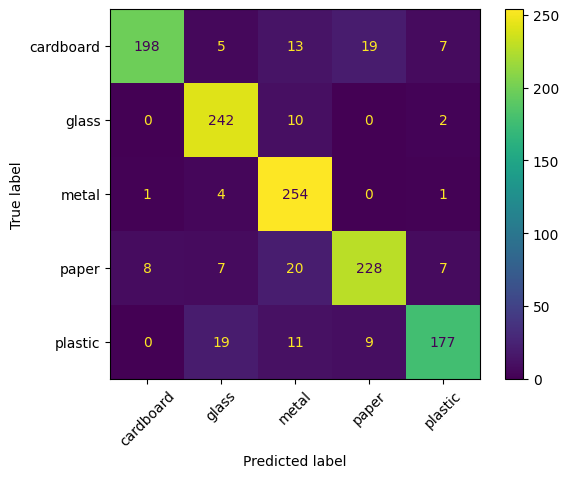

In [15]:
%%time
run2 = runPipeline(
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.001,
    eval_metric="accuracy",
    pipeline_type="predict",
    dataset_name='garbage',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    label2id=label2id,
    id2label=id2label,
    model_checkpoint="garbage/checkpoint-250-final",
    processor=processor,
    torch_weights_filename="AML_p1_v5.pt",
    device=device,
    apply_lora=False,
    load_weights=True
)
executor2 = run2.execute_pipeline()
preds = executor2.predict(test_ds)
run2.visualize_results(preds)